# Introduction

The purposes of this analysis is to utilize the baseball dataset from http://www.seanlahman.com/baseball-archive/statistics/ and apply the core aspects of the data analysis process using pandas. The data analysis process focuses on the following
1. Asking the Question or What is the Question that needs to be answered. 
2. Performing the Data Wrangling Process, to clean up and massage the data to perform further analysis. 
3. Exploring the data, to collect valuable insight. 
4. Drawing Meaningful Conclusions from the results of Exploration.  
5. Communicating the Results of the Analysis 

Coming from a background in cricket, the analysis uses some of the assumptions made in cricket and applies it to the baseball paradigms (especially with respect to batting) and sees if the hypothesis or the assumptions hold true, with that in mind the analysis focusses on the following 

* Analyzing the "Strikeouts" and the "HomeRuns" aspects of the batters and if there is any relationship among the two batting statistics. The other questions that this analysis helps answer is whether a high strikeout for a batter is a bad thing or does it mean that the high strikeout could also mean that higher a chance of a batter clearing the field for a home run? The analysis also goes and extra step and apply a linear regression model between the dependent and the independent variable and confirms or provides positive support to the results of the co-relation analysis
* Analyzing the "Batting Average" and the "Runs Scored" aspects of the batter. This analysis paints a different picture compared to the earlier analysis around "Strikeouts" and HomeRuns". 
* On further analysis around some of the other offensive statistics to look for in batters it came across the OPS is a good metric. OPS looks at not only the ability of the batter to get to base, but also the ability of the batter to HIT. On some more thought, if OPS covers the two important aspects of batting, it made sense to ask the question as to how this co-related with the runs scored by the batter during the season. Hence this analysis was focussed on looking at the "OPS" and the "Runs Scored" and the related co-relation.

*Note:* The data has been available since 1871, however given the fact that the game has evolved so much with better equipment and rules changes, it made sense to perform the analysis in the dataset post 2000

# Coding Action
# Importing the needed libraries and Packages

In [61]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import metrics
%matplotlib inline 

# Reading the needed files for the Analysis

In [62]:
raw_batting_df = pd.read_csv('Batting.csv')
raw_battingpost_df = pd.read_csv('BattingPost.csv')
raw_teams_df = pd.read_csv('Teams.csv')

# Data Wrangling - Checking for Count of Missing AT BAT values in the Data Set
We are going to be doing a lot of analysis based on the one of the batting statistics namely "AT BAT", hence in the cell below I try to see how many records in the data set has a null "AT BAT" value. 

In [63]:
raw_batting_df.AB.isnull().sum()

5149

# Creating two functions for re-use later in the Analysis

Function to Calculate the "Batting Average"

In [64]:
def batting_average(hits, atbats):
    avg = hits/atbats
    return avg


Function to Calculate Correlation between two generic values

In [65]:
def correlation(x, y):
    std_x = (x - x.mean())/x.std(ddof=0)
    std_y = (y - y.mean())/y.std(ddof=0)
    correl = (std_x*std_y).mean()
    return correl

# Data Wrangling Step for the Regular Season Batting Data
For the purposes of this analysis we are going to start of by looking at the batting statistics in the regular season. One of the first steps is to read the original dataframe and extract out the records we think are most relevant for the analysis. For the purposes of the analysis we are going to be considering records post year 2000 and also records that have a positive value for "At Bats. 

Based on some research I did, we could also predict the values of the dependent variables from the independent variables using "test train split" approach that comes with the scikit package (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). This process is called imputation https://en.wikipedia.org/wiki/Imputation_(statistics). However for the purposes of this project we are not going to be doing that. That said, I have tried to give "test train split" approach and calculated the predicted values. I have also calculated the R Square value, which is another measure to explain the proportion of the variance in the dependent variable that is predictable from the independent variable. However these additional statistical tests where done to just cross check the results of my correlation test. 

In [66]:
raw_batting_df_nonzeroab = raw_batting_df[(raw_batting_df.AB>0) & (raw_batting_df.yearID>=2000)].copy()

# Validating the results of extraction

In [67]:
raw_batting_df_nonzeroab.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
79248,abbotje01,2000,1,CHA,AL,80,215.0,31.0,59.0,15.0,...,29.0,2.0,1.0,21.0,38.0,1.0,2.0,2.0,1.0,2.0
79249,abbotku01,2000,1,NYN,NL,79,157.0,22.0,34.0,7.0,...,12.0,1.0,1.0,14.0,51.0,2.0,1.0,0.0,1.0,2.0
79250,abbotpa01,2000,1,SEA,AL,35,5.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
79251,abreubo01,2000,1,PHI,NL,154,576.0,103.0,182.0,42.0,...,79.0,28.0,8.0,100.0,116.0,9.0,1.0,0.0,3.0,12.0
79252,aceveju01,2000,1,MIL,NL,62,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# Analysis 1:  "Strike Outs" v/s "Home Runs" Relationship and What it Means
Coming from a cricketing background, strikeout is referred to as a the batsman getting out. In cricket it is called as getting out. A homerun on the other side is a good thing for a batsman. That said, batters who have a high strikeout rate it might not always be a bad thing. It might just mean that they are very aggressive batters and are willing to take the risk of giving the ball a good hit and send it a long distance and in the process there are occasions when they strikeout, contributing to their high strike rate. On the flipside they could also be racking up some high Homeruns during the season. Hence when coaches look at the Strikeout statistics for certain players in the team it might make sense to see it in correlation with the other positive batting statistics and see if there is any sort of correlation 
	
The purpose of the analysis is to look at the correlation between batsman Strikeouts and Home Runs. For this analysis we are going to be using the Home Runs scored as the dependent variable along Y, and the Strikeouts along the independent variable along X. 
  

Calculating the Correlation between Home Runs and Strikeouts by feeding in the strikeouts and homerun data into the earlier function that was created

In [68]:
strike_outs = raw_batting_df_nonzeroab['SO']
home_runs = raw_batting_df_nonzeroab['HR']
print correlation(home_runs,strike_outs)

0.830856261048


# Scatter plot between Strike outs and Home Runs 

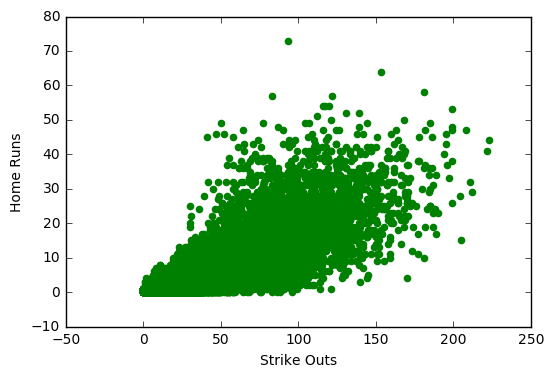

In [69]:
plt.scatter(x=strike_outs,y=home_runs, color='Green')
plt.xlabel('Strike Outs')
plt.ylabel('Home Runs')

# Performing Linear Regression on Strike outs (Independent Variable) and Home Runs (Dependent Variable Y) 

Define features and target

In [70]:
features_labels = ['SO']
target_labels = ['HR']
features = raw_batting_df_nonzeroab[features_labels]
target = raw_batting_df_nonzeroab[target_labels]

Using train_test_split, create training and test subgroups of your data

In [71]:

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size = 0.33, random_state = 42)

Performing Linear Regresion

In [72]:
lr = LinearRegression()
lr.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
lr.intercept_

array([-1.03990906])

In [74]:
lr.coef_

array([[ 0.17988226]])

Calculating R Square Error 

In [75]:
lr.score(features_test, target_test)

0.69902010066465037

Calculating Root Mean Square 

In [76]:
target_pred = lr.predict(features_test)
np.sqrt(metrics.mean_squared_error(target_test, target_pred))

4.5987759342055154

Making Predictions on the Model to get the Predicted Values

In [77]:
target_pred = lr.predict(features_test)
#Comment out the line below to see the targer predicted values based on the linear regression model
# zip(target_pred, target_test.HR)

# Conclusion -  "Strike Outs" v/s "Home Runs" Relationship and What it Means

The analysis presents that there is a 83% percent co-relation between "Strike Outs" and "Home Runs", which probably tells a story that a strikeouts and homeruns move together in the positive direction. Hence only looking at the "Strikeouts" stats for a batter while judging his performance might not be a good indicator.It probably needs to be looked into conjunction with other batting stats and evaluated appropriately.

We also tried to validate the results of the correlation using another stastical test and calculated the R square value. The R Square for our test was 69.9%. The value for R Square can be between 0 and 100%. 

0% indicates that the model explains none of the variability of the response data around its mean.100% indicates that the model explains all the variability of the response data around its mean. Our number of 69.9 (~70%) indicates that the model explains the variability of the predicted data around 70% of the time. 

# Analysis 2:  "Batting Average" v/s "Runs Scored" and what it means
For someone like me who is trying to learn baseball from the heels of a very similar game in cricket,  the batting average is a huge statistic in cricket and in most cases a high batting average in a season more or less means high number of runs scored. The analysis looks at whether batting average is a good measure of the runs scored by a batsman. Ideally speaking (and also based on my experience with following stats in Cricket), a high batting average generally means the batsman is an above average batsman, which should almost always translate to the runs scored. 
	
The purpose of the analysis is to review the correlation between the runs scored by batsman (provided as a part of the dataset) and the batting average, that is yet to be computed based on the data provided. For this analysis I am going to be using runs scored as a the dependent variable along Y, and the calculated batting average as the independent variable along X 

# Data Wrangling - Batting Average

Calculating the batting average using the "Home Runs" and "At Bats". 

We are using the vectorized operation (np.vectorize) to calculate the batting average for each record in the dataframe

In [78]:
raw_batting_df_nonzeroab['batting_average'] = np.vectorize(batting_average)(raw_batting_df_nonzeroab['H'], 
                                                                            raw_batting_df_nonzeroab['AB'])

In [79]:
batting_avg = raw_batting_df_nonzeroab['batting_average']
runs_scored = raw_batting_df_nonzeroab['R']
print correlation(batting_avg,runs_scored)

0.385814905693


# Scatter plot between Batting Average and Runs Scored

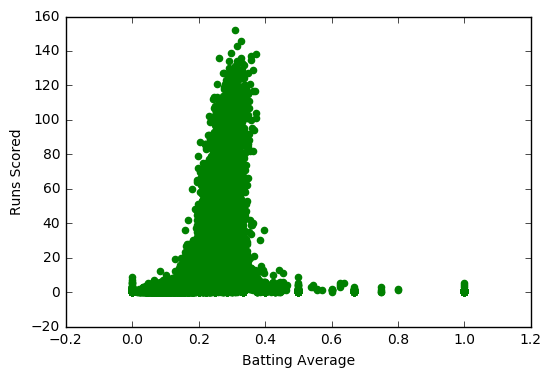

In [80]:
plt.scatter(x=batting_avg,y=runs_scored, color='Green')
plt.xlabel('Batting Average')
plt.ylabel('Runs Scored')

 # Conclusion - "Batting Average" and "Runs  Scored" and what it means

The analysis presents a 38% percent correlation between "Batting Average" and "Home Runs". As a general rule of thumb and based on referencing the material in https://explorable.com/statistical-correlation, for the purposes of our analysis we can assume that "Batting Average" and "Home Runs" have a very weak relationship. 

Hence we should look to analyze some other batting statistics to see the batter efficiency. For the purposes of this project I am not doing further linear regression as performed in the other data set

# Analysis 3: Does a high OPS always translate to Higher Runs being Scored by the Team? 

A lot of baseball statisticians are not a big fan of the traditional batting statistics (e.g. Batting Average,RBI) to evaluate the value of a batter). OPS was created to evaluate the ability of the player to get to bases and the powwer of the batter to get the needed hits. It is fair to assume the the players with high OPS would contribute heavily to the teams runs scored. The purpose of this analysis is to review that hypothesis. 


# Making a copy of the Teams Data Frame to Include Data Post 2000

In [81]:
teams_df = raw_teams_df[(raw_teams_df.yearID>=2000)].copy()
# teams_df.head()

# Fixing the data type on for "AT BATS", "Hits" & "Base on Balls" as Float (Earlier it was set to Integer) 

In [82]:
teams_df.AB = teams_df.AB.astype(float)
teams_df.H = teams_df.H.astype(float)
teams_df.BB = teams_df.BB.astype(float)

In [83]:
teams_df.head(5)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
2325,2000,AL,ANA,ANA,W,3,162,81.0,82,80,...,182.0,0.978,Anaheim Angels,Edison International Field,2066982.0,102,103,ANA,ANA,ANA
2326,2000,NL,ARI,ARI,W,3,162,81.0,85,77,...,138.0,0.982,Arizona Diamondbacks,Bank One Ballpark,2942251.0,105,103,ARI,ARI,ARI
2327,2000,NL,ATL,ATL,E,1,162,81.0,95,67,...,138.0,0.979,Atlanta Braves,Turner Field,3234304.0,101,99,ATL,ATL,ATL
2328,2000,AL,BAL,BAL,E,4,162,81.0,74,88,...,151.0,0.981,Baltimore Orioles,Oriole Park at Camden Yards,3297031.0,95,96,BAL,BAL,BAL
2329,2000,AL,BOS,BOS,E,2,162,81.0,85,77,...,120.0,0.982,Boston Red Sox,Fenway Park II,2585895.0,104,103,BOS,BOS,BOS


# Prior to calculating the OPS, a few other data points needs to be created. The next couple of  cells calculates the intermediate data points before calculating the value for OPS 

# Calculating 1B

In [84]:
teams_df['1B'] = teams_df['H'] - teams_df['2B'] - teams_df['3B'] - teams_df['HR']

# Calculating Total Bases

Total bases (TBs) is the number of bases a player has gained with hits. It is a weighted sum for which the weight value is 1 for a single, 2 for a double, 3 for a triple and 4 for a home run. Only bases attained from hits count toward this total.

In [85]:
teams_df['TB'] = (teams_df['1B'] + (2*teams_df['2B']) + (3*teams_df['3B']) + (4*teams_df['HR']))

# Calculating Slugging Percentage

Slugging percentage(abbreviated SLG) is a popular measure of the power of a hitter. It is calculated as total bases divided by at bats: where AB is the number of at-bats for a given player, and 1B, 2B, 3B, and HR are the number of singles, doubles, triples, and home runs, respectively.

In [86]:
teams_df['SLG'] = teams_df['TB']/teams_df['AB']

# Calculating Onbase Percentage 

Onbase Percentage is measure of how often a batter reaches base for any reason other than a fielding error, fielder's choice, dropped/uncaught third strike, fielder's obstruction, or catcher's interference

In [87]:
teams_df['OBP'] = ((teams_df['H'] + teams_df['BB'] + teams_df['HBP'])/(teams_df['AB']+ teams_df['BB'] + teams_df['SF'] +
                                                                     teams_df['HBP']))

# Calculating Onbase Plus Slugging (OPS) 

OPS adds on-base percentage and slugging percentage to get one number that unites the two. It's meant to combine how well a hitter can reach base, with how well he can hit for average and for power. As a result, OPS is widely considered one of the best evaluative tools for hitters.

In [88]:
teams_df['OPS'] = teams_df['OBP'] + teams_df['SLG']

In [89]:
runs = teams_df['R']
ops =  teams_df['OPS']

In [90]:
print correlation (runs, ops)

0.955407042704


# Conclusion: Does a high OPS always translate to Higher Runs being Scored by the Team?

There is a high degree of positive corelation between OPS and Runs Scored. Hence we can safely assume that teams whose batters would have a high OPS would result in the respective teams having higher runs scored. We could also apply the linear regression as performed in the first analysis to further confirm this theory and calculating the R Squared value. This conclusion by no means states that OPS is the one and only offensive statistics. Recently another good batting statistics that has been thrown around and used a lot is the Weighted On Base Average (WOBA). https://en.wikipedia.org/wiki/WOBA

## References
* http://sabr.org/sabermetrics
* https://www.uu.edu/dept/math/SeniorPapers/01-02/Patterson.pdf
* http://m.mlb.com/glossary/standard-stats/on-base-plus-slugging
* http://myyouthbaseball.com/understanding-using-baseball-statistics.html
* http://www.fangraphs.com/library/offense/ops/
* http://www.eg.bucknell.edu/~bvollmay/baseball/runs1.html
* https://www.uu.edu/dept/math/SeniorPapers/01-02/Patterson.pdf - Refer this 
* http://blog.yhat.com/posts/scraping-and-analyzing-baseball-data-with-r.html
* http://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?article=1000&context=statsp
* http://thesportjournal.org/article/an-examination-of-the-moneyball-theory-a-baseball-statistical-analysis/
* http://emeyers.scripts.mit.edu/emeyers/teaching/cs-0149-introduction-to-statistics-through-baseball/ - 
* https://books.google.com/books?id=1mNZfyil2ecC&pg=PA3&lpg=PA3&dq=what+baseball+statistics+to+statisticians+look+for&source=bl&ots=oY5ykZna04&sig=zvkhx9C0vMghwz-xHxguatZFgnk&hl=en&sa=X&ved=0ahUKEwiQr_7cte_QAhVqzVQKHdehAko4ChDoAQgfMAE#v=onepage&q=what%20baseball%20statistics%20to%20statisticians%20look%20for&f=true
* http://www.predictem.com/mlb/stats.php
